In [2]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass

import DeepStrain.functions_collection as ff
import CMR_HFpEF_Analysis.Image_utils as util

main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_readmission_finalized.xlsx' ))

In [3]:
# find patinet_list
patient_list = spreadsheet.iloc[0:50]
patient_index = 5

ID_0483 1 8
[2, 3, 4, 5, 6, 7, 8, 9] 8
(224, 224, 10)
M shape:  (128, 128, 10)


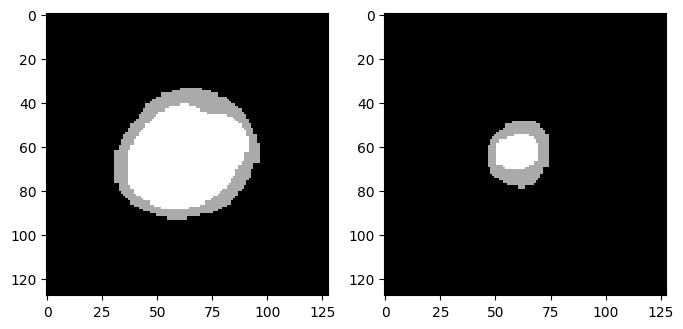

In [9]:
# first: get the ED and ES frame
patient_id_num = patient_list['OurID'].iloc[patient_index]
patient_id = ff.XX_to_ID_00XX(patient_id_num)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)
print(patient_id, ED,ES)

save_folder = os.path.join(main_path, 'results/geometry/', patient_id)
ff.make_folder([save_folder])

# second: load img and seg
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))


# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
new_M_ED = np.zeros_like(M_ED)
new_M_ED[M_ED==1] = 3
new_M_ED[M_ED==2] = 2
M_nifti_ED = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

# fourth: find the number of non-zero slices (that has LV + myocardium segmentation)
slice_nonzero_ed = [i for i in range(new_M_ED.shape[2]) if np.sum(new_M_ED[:,:,i] > 1)>0]
print(slice_nonzero_ed, len(slice_nonzero_ed))
new_M_ED = new_M_ED[:,:,slice_nonzero_ed]
new_M_ED_nifti = nb.Nifti1Image(new_M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

# fifth: resample the image to a uniform number of slices
new_M_ED_nifti = resample_nifti(new_M_ED_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=10)
print(new_M_ED_nifti.get_fdata().shape)

# sixth: crop
center = center_of_mass(new_M_ED_nifti.get_fdata()>1) # RV = 1, Myocardium = 2, LV = 3
M = _roll2center_crop(x=new_M_ED_nifti.get_fdata(), center=center)
print('M shape: ', M.shape)

# seventh: make it start from the base
start_slice = np.copy(M[:,:,1]); start_slice[start_slice >0] = 1
end_slice = np.copy(M[:,:,-2]); end_slice[end_slice >0] = 1
if np.sum(start_slice) < np.sum(end_slice):
    start_slice_name = 'apex'
else:
    start_slice_name = 'base'
if start_slice_name == 'apex':
    M = M[:,:,::-1]

plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(M[:,:,0], cmap='gray')
plt.subplot(122); plt.imshow(M[:,:,-1], cmap='gray')

# eighth: save the image
nb.save(nb.Nifti1Image(M, affine=new_M_ED_nifti.affine, header=new_M_ED_nifti.header), os.path.join(save_folder, 'SAX_ED_seg_for_geometry.nii.gz'))

# calculate the circularity index per slice

In [5]:
M_lv = np.copy(M); M_lv[M_lv != 3] = 0; M_lv[M_lv == 3] = 1
M_lv = M_lv.astype(np.int)
circular_index_img = util.circularity_index_img(M_lv, range(0,10))

# calculate the center dis

In [7]:
centers_delta, centers = util.get_centers(M_lv, range(0,10), make_plot = False)
centers_delta_neighbouring = centers_delta[1:] - centers_delta[:-1]
enclosed_area = util.centers_enclosed_area(centers_delta, make_plot = False)
print('enclosed_area: ', enclosed_area)

enclosed_area:  9.0


# calculate the major and minor axis of each slice as well as the whole volume

In [8]:
from skimage.measure import label, regionprops
# per slice:
axis_len = []
for z in range(0, M_lv.shape[-1]):
    img_slice = M_lv[:,:,z]
    major, minor = util.major_minor_axis_len(img_slice)
    axis_len.append([major, minor])
major, _ = util.major_minor_axis_len(M_lv) # 3D
axis_len.append([major, 10])
axis_len = np.asarray(axis_len)
